<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Imports-and-Initialization" data-toc-modified-id="Imports-and-Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Initialization</a></span><ul class="toc-item"><li><span><a href="#To-Do" data-toc-modified-id="To-Do-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>To Do</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initializing-important-variables" data-toc-modified-id="Initializing-important-variables-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Initializing important variables</a></span></li><li><span><a href="#Load-the-file" data-toc-modified-id="Load-the-file-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load the file</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Part-1:-Segment-and-Identify-the-Cells" data-toc-modified-id="Part-1:-Segment-and-Identify-the-Cells-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 1: Segment and Identify the Cells</a></span><ul class="toc-item"><li><span><a href="#Segmentation-Steps:" data-toc-modified-id="Segmentation-Steps:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Segmentation Steps:</a></span></li><li><span><a href="#Filter-1:-multithreshold-Otsu-filter-+-opening" data-toc-modified-id="Filter-1:-multithreshold-Otsu-filter-+-opening-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filter 1: multithreshold Otsu filter + opening</a></span></li><li><span><a href="#Filter-2:-Convert-the-binary-image-to-a-label-map" data-toc-modified-id="Filter-2:-Convert-the-binary-image-to-a-label-map-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filter 2: Convert the binary image to a label map</a></span></li></ul></li><li><span><a href="#Part-2:-Estimate-curvature-of-each-cell" data-toc-modified-id="Part-2:-Estimate-curvature-of-each-cell-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 2: Estimate curvature of each cell</a></span></li><li><span><a href="#Display-curvature-information" data-toc-modified-id="Display-curvature-information-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Display curvature information</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experiments</a></span></li></ul></div>

# Imports and Initialization

## To Do

* Double check documentation
* Rectify with .py
* Update README
* Run .py for new images from Sara

## Imports

In [1]:
import SimpleITK as sitk

import pylab
import numpy as np
import matplotlib.pyplot as plt
import os

## Initializing important variables

Variables for the user to edit

In [2]:
# Path to the image you want to analyze
inputFn = "./data/sample-01.png"
# Do you want to save intermediate images as figures?
saveIntermediateFigures = False

Other important variables here, not to be changed by the user.

In [3]:
inputFnBase = inputFn.split('/')[-1].split('.')[0]
figPath = "./figures/"+inputFnBase+"/"
if not os.path.exists(figPath):
    os.makedirs(figPath)

## Load the file


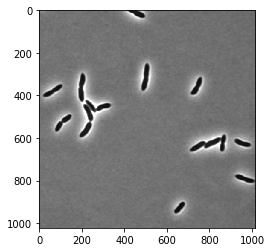

In [4]:
# Set up and execute the image reader
reader = sitk.ImageFileReader()
reader.SetFileName(inputFn)
image = reader.Execute()

# show the image
pylab.imshow(sitk.GetArrayFromImage(image), cmap='gray')

## Preprocessing

In [5]:
# Print basic information about the image
print("Number of image dimensions:", image.GetDimension())
print("Length and width of image:", image.GetSize())
print("Number of components per pixel:", image.GetNumberOfComponentsPerPixel())

imageArray = sitk.GetArrayFromImage(image)
print("Channel 0 == Channel 1:", imageArray[:,:, 0].all() == imageArray[:,:, 1].all())
print("Channel 0 == Channel 2:",imageArray[:,:, 0].all() == imageArray[:,:, 2].all())
print("Channel 1 == Channel 2:", imageArray[:,:, 2].all() == imageArray[:,:, 1].all())

Number of image dimensions: 2
Length and width of image: (1017, 1023)
Number of components per pixel: 4
Channel 0 == Channel 1: True
Channel 0 == Channel 2: True
Channel 1 == Channel 2: True


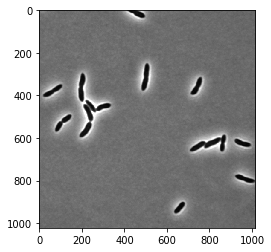

In [6]:
# The image is loaded as a RGBA, but contains the same information 
# in all 3 RGB channels and the 4th channel is luminance. We can extract
# one RGB channel and use that as the image for processing purposes.

# Convert the image to an array
imageArray = sitk.GetArrayFromImage(image)

# Pull the first channel from the array
imageOneChannel = sitk.GetImageFromArray(imageArray[:,:,0])

# Check the information of the single channel image is correct
assert imageOneChannel.GetSize() == image.GetSize()
assert imageOneChannel.GetDimension() == image.GetDimension()
assert imageOneChannel.GetNumberOfComponentsPerPixel() == 1
assert imageOneChannel.GetPixelIDTypeAsString() == "8-bit unsigned integer"

pylab.imshow(sitk.GetArrayFromImage(imageOneChannel), cmap='gray')

image = imageOneChannel

# Part 1: Segment and Identify the Cells

## Segmentation Steps:

Filter 1: Multithreshold Otsu, then opening filter

Filter 2: Convert image to label map

## Filter 1: multithreshold Otsu filter + opening

In [7]:
def segmentCells(origImage, saveIntermediate=False, figFilePath="./"):
    """
    Segment the cells in the original image using multithreshold
    Otsu thresholding followed by opening (to remove small, non-cell
    objects).
    
    Inputs:
    - origImage: the original image (sitk Image)
    - saveIntermediate: flag to indicate whether to save
                        intermediate images (boolean)
    - figFilePath: the path to the location where the figure
                   will be saved (string)

    Returns:
    - segImage: the segmented image (sitk Image)
    """
    # Apply a multiple threshold Otsu filter to the image
    thresholdFilter = sitk.OtsuMultipleThresholdsImageFilter()
    thresholdFilter.SetNumberOfThresholds(2)
    otsuImage = thresholdFilter.Execute(origImage)
    otsuArray = sitk.GetArrayFromImage(otsuImage)
    
    # Save the raw segmentation
    if saveIntermediate:
        outFn = figFilePath+"00-multithreshold-otsu-filtered.png"
        plt.imsave(outFn, otsuArray, cmap='gray')
    
    # Extract the values we care about from the filtered image
    # We know the cells in the phase images should be the darkest
    # Get the darkest thresholded values
    segArray = 1*(otsuArray==0) # (otsuArray==0) produces booleans, multiplying by 1 makes the values int64
    # convert the array back to an image
    segImage = sitk.GetImageFromArray(segArray)
    
    # Pass the segmentation through an opening filter to remove small
    # objects that are not cells
    openingFilter = sitk.BinaryMorphologicalOpeningImageFilter()
    openingFilter.SetKernelRadius(2)
    openingFilter.SetKernelType(sitk.sitkBall)
    segImage = openingFilter.Execute(segImage)
    
    # Save the clean segmentation
    if saveIntermediate:
        outFn = figFilePath+"01-segmentation.png"
        segArray = sitk.GetArrayFromImage(segImage)
        plt.imsave(outFn, segArray, cmap='gray')

    return segImage 

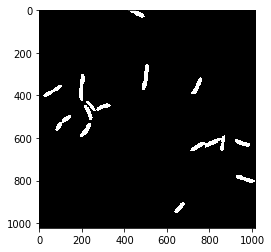

In [8]:
# Segment the preprocessed image
segmentedImage = segmentCells(image, 
                              saveIntermediate=saveIntermediateFigures,
                              figFilePath=figPath)

pylab.imshow(sitk.GetArrayFromImage(segmentedImage), cmap='gray')

## Filter 2: Convert the binary image to a label map

In [9]:
def convertBinToLabelMap(segImage, saveIntermediate=False, figFilePath="./"):
    """
    Convert the binary segmentation image to a label map.
    Each component of the label map will be labelled using
    a separate label (labels are numbers, shown as colors).
    The labels should be separate cells, or closely clumped
    groups of cells.

    Inputs:
    - segImage: the binary segmentation image (sitk Image)
    - saveIntermediate: flag to indicate whether to save
                        intermediate images (boolean)
    - figFilePath: the path to the location where the figure
                   will be saved (string)
    
    Returns:
    - labelImage: the label map image (sitk Image)
    """
    # Set up label map filter
    convertToLabelMap = sitk.BinaryImageToLabelMapFilter()
    labelMap = convertToLabelMap.Execute(segImage)
    labelImageFilter = sitk.LabelMapToLabelImageFilter()
    labelImageFilter.SetNumberOfThreads(4)
    labelImage = labelImageFilter.Execute(labelMap)

    # Show the label map
    pylab.set_cmap('terrain')
    pylab.imshow(sitk.GetArrayFromImage(labelImage))

    # Print information about the label image
    labelArray = sitk.GetArrayFromImage(labelImage)
    print("Number of labels in the label map (including background):",
          np.amax(labelArray)-np.amin(labelArray)+1)

    # Need to change the pixel types
    castFilter = sitk.CastImageFilter()
    castFilter.SetOutputPixelType(sitk.sitkUInt8)
    labelImage = castFilter.Execute(labelImage)

    # The pixel type should be "8-bit unsigned integer"
    assert labelImage.GetPixelIDTypeAsString() == "8-bit unsigned integer"

    if saveIntermediate:
        outFn = figFilePath+"02-labelmap.png"
        segArray = sitk.GetArrayFromImage(segImage)
        plt.imsave(outFn, labelArray, cmap='nipy_spectral')

    return labelImage

Number of labels in the label map (including background): 15


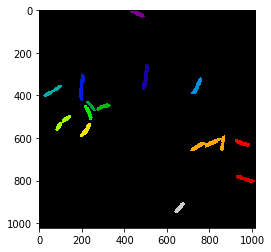

In [10]:
# Get the label map from the binary segmentation image.
labelMap = convertBinToLabelMap(segmentedImage, 
                              saveIntermediate=saveIntermediateFigures,
                              figFilePath=figPath)

pylab.set_cmap('nipy_spectral')
pylab.imshow(sitk.GetArrayFromImage(labelMap))

This image is the label map. Each cell should have its own label in this map.

# Part 2: Estimate curvature of each cell

Define functions to get the contours of the cells and to calculate the curvature of the cells based on the contours.

In [11]:
def getCellContour(cellImage, saveIntermediate=False, figFilePath="./"):
    """
    Given a binary image of a cell, get the contour for that cell.
    
    Inputs:
    - cellImage: binary image mask of one cell (sitk Image)
    - saveIntermediate: flag to indicate whether to save
                        intermediate images (boolean)
    - figFilePath: the path to the location where the figure
                   will be saved (string)
    
    Returns:
    - contourPixels: a list of coordinates that represent the contour
                     of the cell
    """
    contourPixels = []

    # make a contour object of the segmented image
    contourObj = plt.contour(sitk.GetArrayFromImage(cellImage))
    paths = contourObj.collections[0].get_paths()[0]
    contourPixels = paths.vertices
    
    # save the contours to a file; saves all contours to one file because
    # of how this function is called
    if saveIntermediate:
        outFn = figFilePath+"03-contours.png"
        pylab.savefig(outFn, bbox_inches='tight')

    return contourPixels

In [12]:
def calculateContourCurvature(contourPixels):
    """
    Calculate the curvature of the contour of a cell.

    Inputs:
    - contourPixels: the binary image of the skeleton of the cell

    Returns:
    - contourCurvatures: the curvature of the skeleton of the cell
    - contourPixels: the locations of the curvature, as integers
    """
    # Calculate components for curvature
    # Get first derivatives in x and y
    contourPixels = np.asarray(contourPixels)
    dx = np.gradient(contourPixels[:, 0])
    dy = np.gradient(contourPixels[:, 1])

    # Get second derivatives in x and y
    dx2 = np.gradient(dx)
    dy2 = np.gradient(dy) 

    # Calculate the curvature of the curve
    contourCurvature = np.abs(dx2*dy - dx*dy2)/(dx*dx + dy*dy)**1.5
    
    # Threshold curvature values over 1 to be 1
    for i in range(len(contourCurvature)):
        if contourCurvature[i] > 1.0:
            contourCurvature[i] = 1.0            
    
    # Since the contour points may not be integers, make sure they are
    if type(contourPixels[0, 0]) is not int:
        contourPixels = [[int(round(pt[1])), int(round(pt[0]))] for pt in contourPixels]

    return contourCurvature, contourPixels

Apply the 2 functions defined above to the image.

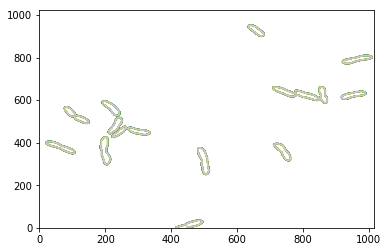

In [13]:
# Calculate the curvatures for all cells in the image
curvatures = []
curves = []
labelArray = sitk.GetArrayFromImage(labelMap)

# Iterate through each label
for label in range(1,np.amax(labelArray)+1):
    singleLabel = (labelMap==label)
    # get the contour for the cell
    singleCurve = getCellContour(singleLabel, 
                                 saveIntermediate=saveIntermediateFigures,
                                 figFilePath=figPath)
    # get the curvature for the cell contour
    singleCurvature, singleCurve = calculateContourCurvature(singleCurve)
    # Add the contour points and the curvatures to the master lists of contours and curvatures
    curvatures.extend(singleCurvature)
    curves.extend(singleCurve)

# Display curvature information

In [14]:
def saveCurvatureOverlay(origImage, curves, curvatures, figFilePath='./'):
    """
    Show the curvatures of the cells on the original image.
    
    Inputs:
    - origImage: the original greyscale image (sitk Image)
    - curves: the locations of the cell curves (list of lists of ints)
    - curvatures: the curvatures of the curves (list of floats)
    - figFilePath: the path to the location where the figure
                   will be saved (string)
                   
    Effects:
    - Makes a composite image consisting of the original image
    overlaid with colored versions of the curvatures. Also includes
    a colorbar.
    """
    # Make a new figure and show the original image
    pylab.figure(figsize=(35,25))
    pylab.set_cmap('gray')
    pylab.imshow(sitk.GetArrayFromImage(origImage))

    # Set up the overlay image
    shape = origImage.GetSize()
    overlay = np.zeros((shape[1], shape[0]))
    # Make the value 0.0 appear transparent
    overlay[overlay == 0.0] = np.nan

    # Iterate through the curve points and curvatures
    for point, value in zip(curves, curvatures):
        # Since we're capping the curvature value at 1 (potential miscalculations),
        # make sure the curvature values being plotted are at most 1.
        if value < 1:
            overlay[point[0], point[1]] = value
        else:
            overlay[point[0], point[1]] = 1
    
    # Combine the overlay image and the original image
    pylab.imshow(overlay, 'rainbow', alpha=1)
    # Add a colorbar
    pylab.colorbar()

    # Save the image with the curvatures
    outFn = figFilePath+'curvatures.png'
    pylab.savefig(outFn, bbox_inches='tight')

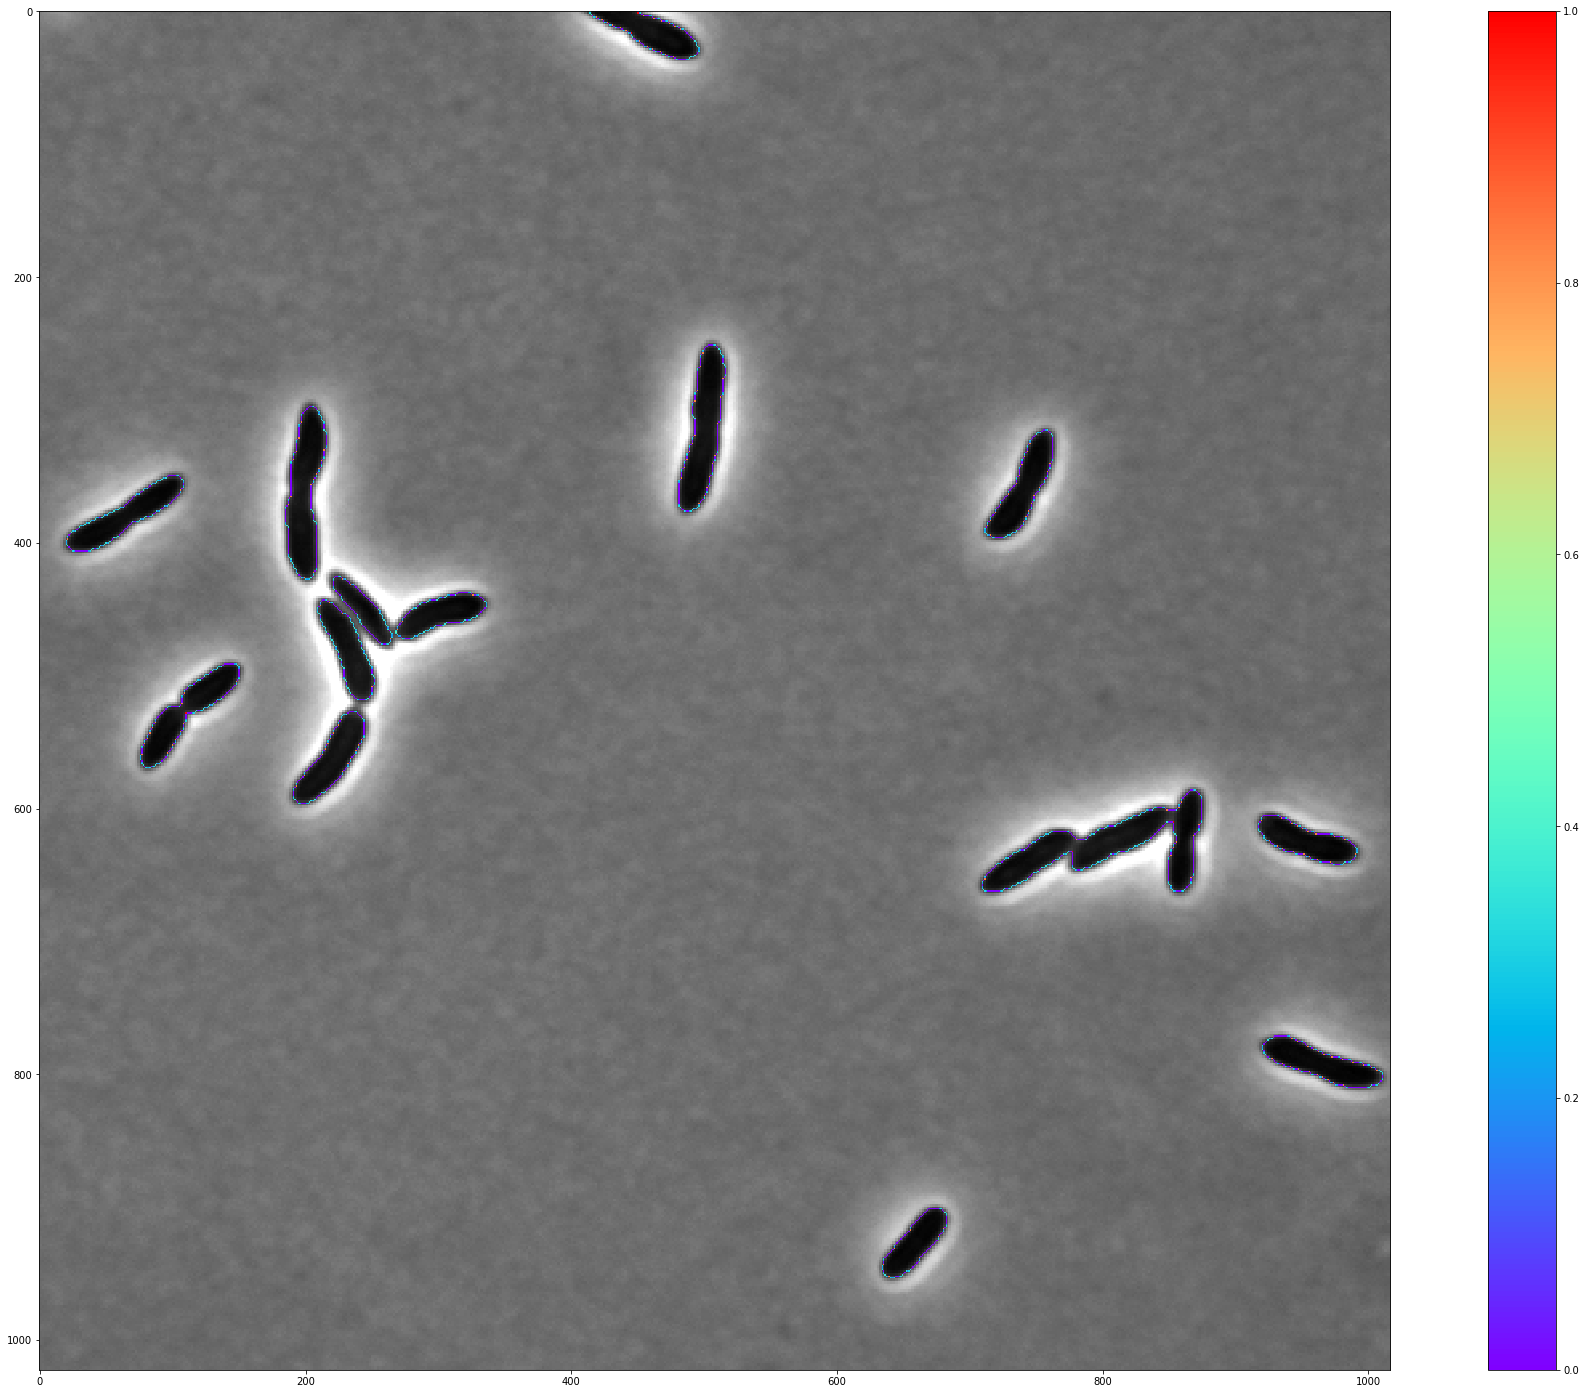

In [15]:
# Make the composite original image with curvatures
saveCurvatureOverlay(image, curves, curvatures, figFilePath=figPath)

In [16]:
def saveCurvatureHistogram(curvatures, figFilePath='./'):
    """
    Given the list of curvature values, create a histogram of those
    values and save the histogram as a figure.
    
    Inputs:
    - curvatures: a list of the curvature values (list of floats)
    - figFilePath: the path to the location where the figure
                   will be saved (string)
                   
    Effects:
    - Prints a text table of statistics about the curvature
    histogram
    - Makes a histogram of the curvatures and saves it in the
    designated location
    """
    # set the number of bins
    numBins = 20
    outFn = figFilePath+'curvature-histogram.png'
    
    # print information about the histogram
    print('Curvature Statistics')
    print('---------------------------------------')
    print('Min:               ', np.amin(curvatures))
    print('Mean:              ', np.mean(curvatures))
    print('Median:            ', np.median(curvatures))
    print('Max:               ', np.amax(curvatures))
    print('Standard Deviation:', np.std(curvatures))
    
    # show the histogram
    pylab.figure(figsize=(7,7))
    pylab.hist(curvatures, numBins, facecolor='blue', alpha=0.7)
    pylab.title('Histogram of Curvatures')
    pylab.xlabel(u'Curvature (${\mu}m^{-1}$)')
    pylab.ylabel('Frequency')
    
    # save the histogram
    pylab.savefig(outFn, bbox_inches='tight')

Curvature Statistics
---------------------------------------
Min:                0.0
Mean:               0.1936126504360356
Median:             0.037499999999994316
Max:                1.0
Standard Deviation: 0.24603088686639632


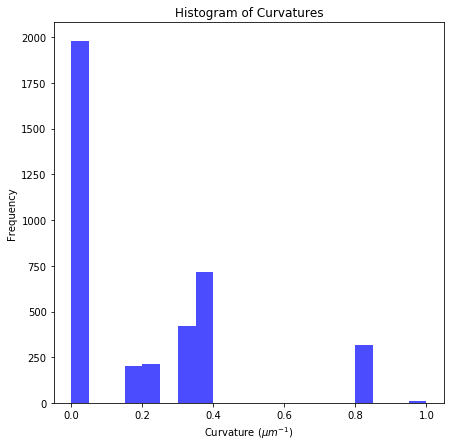

In [17]:
# Show a histogram of curvatures
saveCurvatureHistogram(curvatures, figFilePath=figPath)

# Experiments

In [ ]:
# Fit a polynomial to the segmented blob
# get the label map
singleLabel = (labelMap==2)
# get the locations of the nonzero pixels
segPixels = np.argwhere(sitk.GetArrayFromImage(singleLabel) > 0)
print(segPixels.shape)
# fit a polynomial to those pixels
segPixels = np.transpose(segPixels)
print(segPixels.shape)
polyX = np.poly1d(np.polyfit(, segPixels[0], deg=3))
polyY = np.poly1d(np.polyfit(, segPixels[1], deg=3))

# Calculate the curvature of the polynomial
polyFirst = poly.deriv(1)
polySecond = poly.deriv(2)
print(polyFirst)
print(polySecond)
# Calculate components for curvature
# Get first derivatives in x and y
dx = np.gradient(curvePixels[:, 0])
dy = np.gradient(curvePixels[:, 1])

# Get second derivatives in x and y
dx2 = np.gradient(dx)
dy2 = np.gradient(dy) 

# Calculate the curvature of the skeleton curve
skelCurvature = np.abs(dx2*dy - dx*dy2)/(dx*dx + dy*dy)**1.5